In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import dask.dataframe as dd
from toolbox.data_aggregation import *
from toolbox.linear_reg import *
import datetime
from datetime import timedelta, date
import numpy as np

In [2]:
df_train = pd.read_csv(
    'data/train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 115688780)  # 2017-01-01 sharp = 101688780!
)

In [3]:
df_train.head() #2017-05-15

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2017-05-15,6,1963363,1.098612,False
1,2017-05-15,6,1963540,0.693147,False
2,2017-05-15,6,1963561,0.693147,False
3,2017-05-15,6,1963606,2.639057,False
4,2017-05-15,6,1963740,1.098612,False


In [4]:
items = pd.read_csv(
    "data/items.csv",
).set_index("item_nbr")

In [5]:
promo_train = df_train.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)

In [6]:
promo_train.columns = promo_train.columns.get_level_values(1)

In [7]:
df_train = df_train.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_train.columns = df_train.columns.get_level_values(1)

In [8]:
items = pd.read_csv(
    "data/items.csv",
).set_index("item_nbr")

In [9]:
items = items.reindex(df_train.index.get_level_values(1))

In [10]:
def get_timespan(df, dt, minus, periods):
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods)
    ]

In [11]:
def prepare_sample(df_raw, promo_raw, sample_dt, is_train=True):
    X = pd.DataFrame({
        "mean_3": get_timespan(df_raw, sample_dt, 3, 3).mean(axis=1).values,
        "mean_7": get_timespan(df_raw, sample_dt, 7, 7).mean(axis=1).values,
        "mean_14": get_timespan(df_raw, sample_dt, 14, 14).mean(axis=1).values,
        "promo_14_sum": get_timespan(promo_raw, sample_dt, 14, 14).sum(axis=1).values
    })
    for i in range(16):
        X["promo_{}".format(i)] = promo_raw[
            sample_dt + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_raw[
            pd.date_range(sample_dt, periods=16)
        ].values
        return X, y
    return X

In [12]:
date(2017, 7, 31) - date(2017, 6, 1)

datetime.timedelta(60)

# Generate samples from certain days
Each day with different combination of store and item

In [13]:
some_date = date(2017, 6, 1)
X_l, y_l = [], []
for i in range(10):
    delta = timedelta(days=i*6)
    X_tmp, y_tmp = prepare_sample(
        df_train, promo_train, some_date + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1584100 entries, 0 to 158409
Data columns (total 20 columns):
mean_14         1584100 non-null float64
mean_3          1584100 non-null float64
mean_7          1584100 non-null float64
promo_14_sum    1584100 non-null int64
promo_0         1584100 non-null uint8
promo_1         1584100 non-null uint8
promo_2         1584100 non-null uint8
promo_3         1584100 non-null uint8
promo_4         1584100 non-null uint8
promo_5         1584100 non-null uint8
promo_6         1584100 non-null uint8
promo_7         1584100 non-null uint8
promo_8         1584100 non-null uint8
promo_9         1584100 non-null uint8
promo_10        1584100 non-null uint8
promo_11        1584100 non-null uint8
promo_12        1584100 non-null uint8
promo_13        1584100 non-null uint8
promo_14        1584100 non-null uint8
promo_15        1584100 non-null uint8
dtypes: float64(3), int64(1), uint8(16)
memory usage: 84.6 MB


# Shuffle and split
date, store, item are all randomized

In [15]:
from sklearn.model_selection import train_test_split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import learning_curve
# multi_sgd_reg = MultiOutputRegressor(SGDRegressor(), n_jobs=-1)
# train_sizes, train_scores, valid_scores = learning_curve(
#     multi_sgd_reg, X_train_s, y_train_s, scoring='neg_mean_squared_error', cv=5
# )
# train_scores = np.sqrt(-train_scores)
# valid_scores = np.sqrt(-valid_scores)

In [17]:
# plt.plot(train_sizes, train_scores, 'b-')
# plt.plot(train_sizes, valid_scores, 'r-')
# plt.ylim([0, 1])
# plt.title("Learning curve for Linear Regression (SGD)")
# plt.xlabel("# of Examples")
# plt.ylabel("RMSE")

# Selection a very small portion for development

In [18]:
DEV_SCALE = 0.01
m = int(X_train_s.shape[0] * DEV_SCALE)

In [19]:
from xgboost import XGBRegressor
# xgb_reg = XGBRegressor()
# X_dev = X_train_s[:m]
# y_dev = y_train_s[:m]

In [20]:
# result = []
# for col in range(16):
#     xgb_reg.fit(X_dev, y_dev[:, col])
#     y_pred = xgb_reg.predict(X_dev)

#     mse = mean_squared_error(y_dev[:, col], y_pred)
#     result.append(np.sqrt(mse))
# print(result)

In [21]:
m_list = np.linspace(100, m, 10)

# Learning curve for XGB

In [22]:
from sklearn.metrics import mean_squared_error
results = np.zeros([10, 16])
results_t = np.zeros([10, 16])
xgb_reg = XGBRegressor()
for i in range(10):
    m_temp = m_list[i]
    X_temp = X_train_s[:int(m_temp)]
    y_temp = y_train_s[:int(m_temp)]
    result = []
    result_t = []
    for col in range(16):
        xgb_reg.fit(X_temp, y_temp[:, col])
        y_pred = xgb_reg.predict(X_train_s[-1000:])
        y_pred_t = xgb_reg.predict(X_temp)
        mse = mean_squared_error(y_train_s[-1000:, col], y_pred)
        mse_t = mean_squared_error(y_temp[:, col], y_pred_t)
        result.append(np.sqrt(mse))
        result_t.append(np.sqrt(mse_t))
        
    results[i, :] = result
    results_t[i, :] = result_t

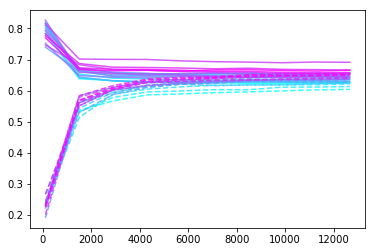

In [23]:
from matplotlib import cm
for i in range(16):
    plt.plot(m_list, results[:, i], '-', color=cm.cool(i/15), alpha=0.8)
    plt.plot(m_list, results_t[:, i], '--', color=cm.cool(i/15), alpha=0.8)

In [24]:
def prepare_sample_2(df_raw, promo_raw, sample_dt, is_train=True):
    X = pd.DataFrame({
        "mean_3": get_timespan(df_raw, sample_dt, 3, 3).mean(axis=1).values,
        "mean_7": get_timespan(df_raw, sample_dt, 7, 7).mean(axis=1).values,
        "mean_14": get_timespan(df_raw, sample_dt, 14, 14).mean(axis=1).values,
        "promo_14_sum": get_timespan(promo_raw, sample_dt, 14, 14).sum(axis=1).values,
        "perishable": items['perishable'].values,
    })
    for i in range(16):
        X["promo_{}".format(i)] = promo_raw[
            sample_dt + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_raw[
            pd.date_range(sample_dt, periods=16)
        ].values
        y = np.multiply(y, 1 + 0.118 * items['perishable'].values.reshape([-1, 1]))
        return X, y
    return X

In [25]:
temp_X2, temp_y2 = prepare_sample_2(df_train, promo_train, some_date)

# Target modification to fit official evaluation

In [26]:
some_date = date(2017, 6, 1)
X_l, y_l = [], []
for i in range(10):
    delta = timedelta(days=i*6)
    X_tmp, y_tmp = prepare_sample_2(
        df_train, promo_train, some_date + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l

In [27]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
from sklearn.metrics import mean_squared_error
results = np.zeros([10, 16])
results_t = np.zeros([10, 16])
xgb_reg = XGBRegressor()
for i in range(10):
    m_temp = m_list[i]
    X_temp = X_train_s[:int(m_temp)]
    y_temp = y_train_s[:int(m_temp)]
    result = []
    result_t = []
    for col in range(16):
        xgb_reg.fit(X_temp, y_temp[:, col])
        y_pred = xgb_reg.predict(X_test_s)
        y_pred_t = xgb_reg.predict(X_temp)
        mse = mean_squared_error(y_test_s[:, col], y_pred)
        mse_t = mean_squared_error(y_temp[:, col], y_pred_t)
        result.append(np.sqrt(mse))
        result_t.append(np.sqrt(mse_t))
        
    results[i, :] = result
    results_t[i, :] = result_t

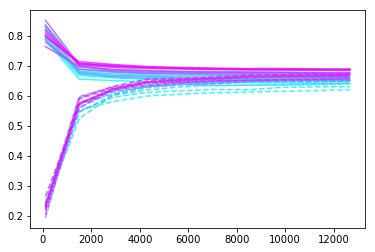

In [29]:
for i in range(16):
    plt.plot(m_list, results[:, i], '-', color=cm.cool(i/15), alpha=0.8)
    plt.plot(m_list, results_t[:, i], '--', color=cm.cool(i/15), alpha=0.8)

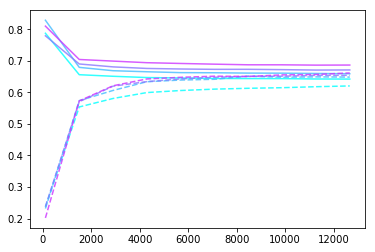

In [30]:
for i in range(0, 16, 4):
    plt.plot(m_list, results[:, i], '-', color=cm.cool(i/15), alpha=0.8)
    plt.plot(m_list, results_t[:, i], '--', color=cm.cool(i/15), alpha=0.8)